In [128]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers


In [129]:
# Loading the data
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data/PlantVillage/',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [130]:
# Check the class names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [131]:
# Inspect the length and shape of the dataset
print(len(dataset))


68


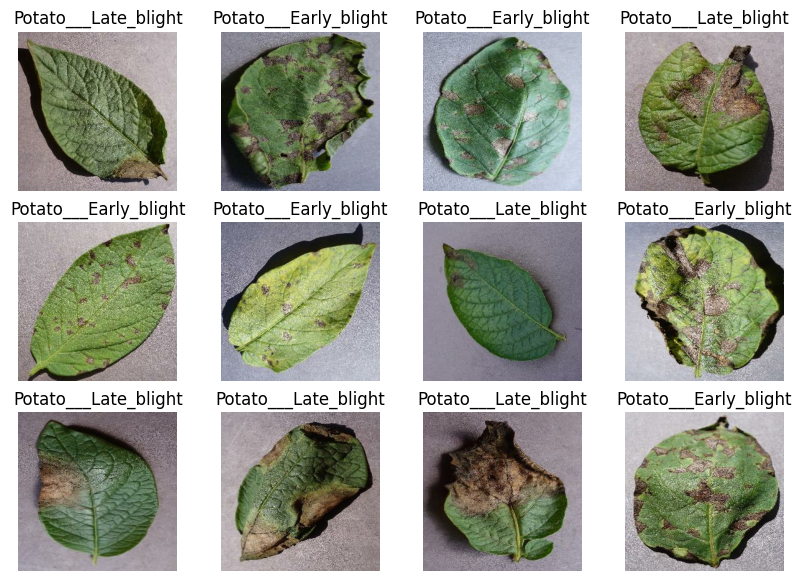

In [132]:
# Check the respective images
plt.figure(figsize=(10,7))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [133]:
# Splitting the train, test and validation set
# Train set
train_ds = dataset.take(54)
print("Train Dataset: ", len(train_ds))

# Sample Test set
sample_test_set = dataset.skip(54)
print("Sample Test Dataset: ", len(sample_test_set))

# Validation set
val_ds = sample_test_set.take(6)
print("Validation Dataset: ", len(val_ds))

# Test set
test_ds = sample_test_set.skip(6)
print("Actual Test Dataset: ", len(test_ds))




Train Dataset:  54
Sample Test Dataset:  14
Validation Dataset:  6
Actual Test Dataset:  8


In [134]:
# Function to split the dataset into train, validation and test sets.
def get_dataset_partition_tf(ds, train_split= 0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    df_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [135]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)
len(train_ds)

54

In [136]:
len(val_ds)

6

In [137]:
len(test_ds)

8

In [138]:
# Caching the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [139]:
# Preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [140]:
# Data Augementation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [141]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the model

In [142]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS,)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [143]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_42 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (32, 60, 60, 64)        

In [144]:
# Compiling the model 
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [145]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
 5/54 [=>............................] - ETA: 1:04 - loss: 0.9958 - accuracy: 0.3625

KeyboardInterrupt: 

In [146]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 290ms/step - loss: 0.9808 - accuracy: 0.5039


### The model performs well with an accuracy of 98% with is quite good. 

In [147]:
scores

[0.9808088541030884, 0.50390625]

### Plotting the Accuracy and loss curves

In [148]:
history
print("History Params:", history.params)
print("History Keys:", history.history.keys())

History Params: {'verbose': 1, 'epochs': 50, 'steps': 54}
History Keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [149]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (40,) and (50,)

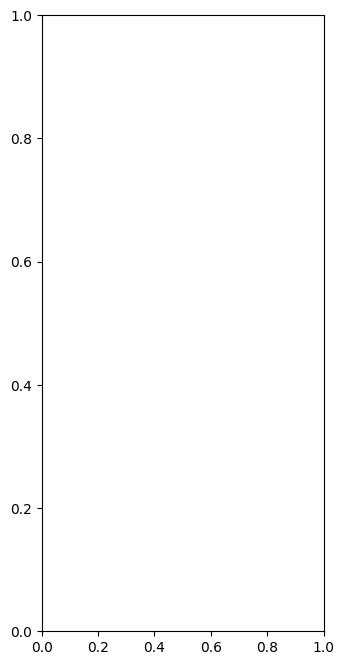

In [150]:
# Plotting the curves
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()